In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import time
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data_pickle5 import ExprDataPickle5 as ExprData
from helpers.scale_data import ScaleData
from helpers.similarity_nophase import SimilarityNoPhase as Similarity
from helpers.feature_selection_nopearson import FeatureSelectionNoPearson as FeatureSelection

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
import random
np.random.seed(47907)
random.seed(15213)

In [3]:
OVERALL_PLOT = False

In [4]:
# read in the performance metrics for each experiment
data_all = ExprData()
data_all.load_pickle()
data_all = data_all.merge_tpch()
data = data_all.remove_by_wlname(['xml', 'ycsb'])
ycsb_data = data_all.remove_by_wlname(['xml', 'tpcc', 'tpch', 'twitter'])
data = data.merge_tpch()

In [5]:
candid_idx = len(ycsb_data.wl_names) - 3
all_groups = ['10', '11', '12']
candidate_group = '10'
ycsb_data = ycsb_data.remove_by_group([g for g in all_groups if g != candidate_group])

In [6]:
X_label = 'SKU'
expr_label = 'EXPR'
y_true_label = 'Y_TRUE'
y_pred_label = 'Y_PRED'
suffix_labels = ['_small', '_large']

In [7]:
# similarity for all
new_data = data.keep_complete_exprs()

scaler = ScaleData()
plan_mtxs, plan_col_ranges = scaler.scale(new_data.plan_mtxs)
perf_mtxs, perf_col_ranges = scaler.scale(new_data.perf_mtxs)

simi_calc_all = Similarity(new_data, plan_mtxs, plan_col_ranges, perf_mtxs, perf_col_ranges)
simi_calc_all.calc_bined_mtx() # all plan features

simi_calc = simi_calc_all
fs = FeatureSelection(simi_calc)

all_top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type=None)

120 120 120 120


In [8]:
sampled_data = new_data.sample_data()

In [9]:
data_by_type = sampled_data.split_by_type()

In [10]:
sampled_by_type = sampled_data.split_by_type()
for ty, expr_set in sampled_by_type.items():
    sub_by_term = expr_set.split_by_term()
    sampled_by_type[ty] = sub_by_term

In [11]:
def get_top_k_features(simi_calc, k=7):
    # Use top-k feature from all features
    fs = FeatureSelection(simi_calc)
    
    top_k = fs.select_features(k, 'fANOVA', est_name=None, direction=None, feature_type=None)
    plan_top_k = fs.select_features(k, 'fANOVA', est_name=None, direction=None, feature_type='plan')
    print(top_k)
    print(plan_top_k)
    return top_k, plan_top_k

In [12]:
def unroll_mtx(mtx):
    return (mtx.T).ravel()

In [13]:
def unroll_all(simi_calc, keep_dims):
    ndarrs = [np.array(b[:, keep_dims].astype(float)) for b in simi_calc.cumulative_bined]
    unrolled_ndarrs = np.array([unroll_mtx(b) for b in ndarrs])
    return unrolled_ndarrs

In [14]:
def get_cpu_nums_as_X(l):
    return np.array([int(e[3:]) for e in l]).reshape(-1, 1)

In [15]:
def plot_prediction(dfs, method, show_fig=True):
    # plot all trends 
    colors = ['#1b9e77','#7570b3','#d95f02','#e7298a']
    fig, ax = plt.subplots()
        
    pred_label_add = False
    # exprs = []
    pred_color = colors[0]
    overall_expr_label_add = False
    expr_tracker = 0
    for df in dfs:
        expr_label_add = False
        
        expr_label_add = False
        for _, row in df.iterrows():
            run_color = colors[1+expr_tracker%3]
            curr_x = [row[f'{X_label}{suffix}'] for suffix in suffix_labels]
            expr_tracker += 1
            true_y = [row[f'{y_true_label}{suffix}'] for suffix in suffix_labels]
            pred_y = [row[f'{y_true_label}{suffix_labels[0]}'], row[f'{y_pred_label}{suffix_labels[1]}']]
            
            if not pred_label_add:
                pred_label_add = True
                pred_l = ax.plot(curr_x, pred_y, '-o', color=pred_color, linewidth=1, label='Predict_y')
            else:
                ax.plot(curr_x, pred_y, '-o', color=pred_color, linewidth=1)
                
            if not overall_expr_label_add:
                if not expr_label_add and expr_tracker % 3 == 2:
                    expr = ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=1.5, label='True_y')
                    expr_label_add = True
                else:
                    ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=1.5, label='  ')
            else:
                ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=1.5)
        overall_expr_label_add = True

                
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    
    # l = ax.legend([tuple(exprs), pred_l], ['True_y', 'Predict_y'])
    plt.legend(bbox_to_anchor=(0,0.15), loc="lower left")
    plt.savefig(f'figs/prediction/ycs_pred_{method}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [16]:
'''
Use a dictionary of models
- key: (lower SKU, higher SKU)
- value: model
'''
def predict(model_dicts, X, y_true, expr_idxs, method, show_fig=True):
    overall_data = pd.DataFrame(zip(X, expr_idxs, y_true), columns=[X_label, expr_label, y_true_label])

    # for each pair of SKU
    num_cpus = np.sort(np.unique(X))
    test_scores = []
    models, datas_big, datas_small = [], [], []
    dfs = []
    
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            
            curr_smaller = overall_data[overall_data[X_label] == cpu_a]
            curr_bigger = overall_data[overall_data[X_label] == cpu_b]
            
            new_preds = []
            
            for model_dict in model_dicts:            
                new_y_true, new_y_pred = [], []

                curr_smaller_pred = model_dict[(cpu_a, cpu_b)].predict(curr_smaller[X_label].to_numpy().reshape(-1, 1))
                curr_bigger_pred = model_dict[(cpu_a, cpu_b)].predict(curr_bigger[X_label].to_numpy().reshape(-1, 1))
                curr_smaller = curr_smaller.assign(Y_PRED=curr_smaller_pred)
                curr_bigger = curr_bigger.assign(Y_PRED=curr_bigger_pred)

                for _, smaller_row in curr_smaller.iterrows():
                    curr_expr_idx = smaller_row[expr_label]
                    curr_diff = smaller_row[y_true_label] - smaller_row[y_pred_label]
                    bigger_row = curr_bigger[curr_bigger[expr_label] == curr_expr_idx]
                    assert(bigger_row.shape[0] == 1)
                    bigger_row = bigger_row.iloc[0]
                    new_y_true.append(bigger_row[y_true_label])
                    new_y_pred.append(bigger_row[y_pred_label] + curr_diff)
                new_preds.append(new_y_pred)
            
            curr_bigger = curr_bigger.assign(Y_PRED=np.mean(np.array(new_preds), axis=0))
            df = pd.merge(curr_smaller, curr_bigger, on=[expr_label], suffixes=suffix_labels)
            dfs.append(df)
            
            new_y_true = np.array(new_y_true)
            new_y_pred = np.array(new_y_pred) 
            
            score = np.sqrt(((new_y_true-new_y_pred)**2).mean())/(np.max(new_y_true) - np.min(new_y_true))
            test_scores.append(score)
                
            models.append(model_dict[(cpu_a, cpu_b)])
            datas_small.append(curr_smaller)
            datas_big.append(curr_bigger)

    plot_prediction(dfs, method, show_fig)
    print(np.max(y) - np.min(y))
    # overall_score = np.sqrt((np.array(test_scores)**2).mean())/(np.max(y) - np.min(y))
    overall_score = np.mean(test_scores)
    return overall_score

In [17]:
ycsb_X = get_cpu_nums_as_X(ycsb_data.cpu_nums)
ycsb_y = np.array(ycsb_data.wl_throughput)
ycsb_expr = np.array(ycsb_data.sampled_run_idx)

In [18]:
random_effect = 'EXPR_ID'
fixed_effect = 'SKU_VALUE'
target_metric = 'throughput'

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [20]:
all_results = {}
all_times = {}

## MARS

random_effect = 'EXPR_ID'
fixed_effect = 'SKU_VALUE'
target_metric = 'throughput'

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from pyearth import Earth
# import plotly.graph_objects as go # for data visualization
# import plotly.express as px # for data visualization

In [22]:
random_effect = 'EXPR_ID'
fixed_effect = 'SKU_VALUE'
target_metric = 'throughput'

X_label = fixed_effect
y_label = target_metric

In [23]:
# def plot_mars_graph_all(model, data, groups, metric, fig_name, show_fig=False):
def plot_mars(models, X, y, workload_name, group_type, groupping_id, show_fig=False):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
    
    x_new = np.linspace(0, np.max(X)*1.1, 100)
    
    plt.figure(figsize=(4, 3))
    ax = plt.axes()
    ax.scatter(X.reshape(-1,1), y, color=color)
    for model in models:
        y_new = model.predict(x_new[:, np.newaxis])
        ax.plot(x_new, y_new, color=color)
    
    # y_new = model.predict(x_new[:, np.newaxis])
    # ax.plot(x_new, y_new, color=color)
    
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.savefig(f'figs/prediction/mars_all_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [24]:
def build_mars_model(X, y, wl_name, grouping_type, groupping_id, expr_ids, plot=False, show_fig=False):
    metrics = [fixed_effect, random_effect, target_metric]
    zipped = zip(X, expr_ids, y)

    # append fixed effect and random effect to data
    curr_data = pd.DataFrame(zipped, columns=metrics)
    curr_data['tag'] = curr_data[fixed_effect].astype(str) + "_" + curr_data[random_effect].astype(str)
    x_columns = [fixed_effect]
    num_cpus = np.sort(np.unique(X))

    train_rmses, test_rmses = [], []
    
    train_time = 0
    
    k = 5
    models = []   
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(curr_data):
        start = time.time()
        data = curr_data.iloc[train_index]
        test = curr_data.iloc[test_index]
        
        model = Earth(enable_pruning=True, max_terms=10, allow_linear=True, max_degree=1, penalty=1, endspan_alpha=0.01)
        model.fit(data[x_columns], data[target_metric])

        test_preds = np.array(model.predict(test[x_columns]))
        train_preds = model.predict(data[x_columns])
        
        end = time.time()
        train_time += end - start
        
        for i in range(len(num_cpus)):
            for j in range(i, len(num_cpus)):
                if i == j:
                    continue
                cpu_a = num_cpus[i] # smaller
                cpu_b = num_cpus[j] # larger
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in test[fixed_effect].to_list()]
                
                curr_y_true = test[y_label].to_numpy()[curr_mask]
                rmse = np.sqrt(((curr_y_true-test_preds[curr_mask])**2).mean())
                n_rmse = rmse / (np.max(curr_y_true)-np.min(curr_y_true))
                test_rmses.append(n_rmse)
                
                curr_mask = [x_lab == cpu_a or x_lab == cpu_b for x_lab in data[fixed_effect].to_list()]
                
                curr_y_true = data[y_label].to_numpy()[curr_mask]
                rmse = np.sqrt(((curr_y_true-train_preds[curr_mask])**2).mean())
                n_rmse = rmse / (np.max(curr_y_true)-np.min(curr_y_true))
                train_rmses.append(n_rmse)

    models.append(model)
    train_time /= k
    
    # calculate overall rmse
    overall_train_rmse = np.mean(train_rmses)
    overall_test_rmse = np.mean(test_rmses)
    
    plot_mars(models, X, y, wl_name, grouping_type, groupping_id, show_fig)

    # return overall_test_r2, overall_train_r2
    return overall_test_rmse, overall_train_rmse, train_time

In [25]:
test_r, train_r = [], []
group_to_model_dict = {} 
all_results['MARS'] = {}
all_times['MARS'] = {}

for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['MARS']:
        all_results['MARS'][name] = {}
        all_times['MARS'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    X = get_cpu_nums_as_X(curr_data.cpu_nums).flatten()
    y = curr_data.wl_throughput
    out_name = '{}_group{}_term{}'.format(curr_data.wl_names[0], ty, curr_data.terminal_num[0])
    
    expr_idxs = list(map(int, curr_data.run_idx))
    test_r2_mean, train_r2_mean, train_time = build_mars_model(X, y, curr_data.wl_names[0], 
                                                               'group', curr_data.wl_groups[0], expr_idxs,
                                                               plot=OVERALL_PLOT, show_fig=False)

    test_r.append(test_r2_mean)
    train_r.append(train_r2_mean)
    all_results['MARS'][name][term] = test_r2_mean
    all_times['MARS'][name][term] = train_time
    print('Test r2 = {}, Train r2 = {}'.format(test_r2_mean, train_r2_mean))
print('Mean: Test r2 = {}, Train r2 = {}'.format(np.mean(test_r), np.mean(train_r)))
print('Median: Test r2 = {}, Train r2 = {}'.format(np.median(test_r), np.median(train_r)))

Group Id: 1, wl name tpcc, terminal num 32
Test r2 = 0.27910385348973527, Train r2 = 0.21215965665837488
Group Id: 2, wl name tpch, terminal num 1
Test r2 = 0.24949788426955885, Train r2 = 0.21253593112209543
Group Id: 3, wl name twitter, terminal num 32
Test r2 = 0.30682257991682527, Train r2 = 0.22376672381477422
Group Id: 4, wl name twitter, terminal num 8
Test r2 = 0.3559548810563378, Train r2 = 0.30675069035426555
Group Id: 7, wl name tpcc, terminal num 8
Test r2 = 0.3047005540270078, Train r2 = 0.2601810962531474
Group Id: 8, wl name tpcc, terminal num 4
Test r2 = 0.3014340370604629, Train r2 = 0.2526542375444124
Group Id: 9, wl name twitter, terminal num 4
Test r2 = 0.30171753960538716, Train r2 = 0.28651591349780475
Mean: Test r2 = 0.2998901899179022, Train r2 = 0.2506520356064107
Median: Test r2 = 0.30171753960538716, Train r2 = 0.2526542375444124


In [26]:
terminals = [4, 8, 32]
workloads = ['tpcc', 'twitter', 'tpch']
methods = ['MARS']

for me in methods:
    curr_line = ''
    scs = []
    times = []
    for wl in workloads:
        if wl == 'tpch':
            sc = abs(all_results[me][wl][1])
            curr_line += f' {sc:.3f} &'
            scs.append(sc)
            times.append(all_times[me][wl][1])
        else:
            for ter in terminals:
                sc = abs(all_results[me][wl][ter])
                curr_line += f' {sc:.3f} &'
                scs.append(sc)
                times.append(all_times[me][wl][ter])
    curr_line += f' {np.mean(scs):.3}'
    curr_line += " \\\\ \hline \hline"
    curr_line = f'& {me} & ' + f' {np.mean(times):.4f} & ' + curr_line
    print(curr_line)

& MARS &  0.0187 &  0.301 & 0.305 & 0.279 & 0.302 & 0.356 & 0.307 & 0.249 & 0.3 \\ \hline \hline


In [27]:
def plot_mars_indi(models, datas, workload_name, group_type, groupping_id, show_fig=False):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
        
    fig, ax = plt.subplots()

    for model, data, line_c in zip(models, datas, colors):
        x_new = np.linspace(np.max(data[X_label]), np.min(data[X_label]), num=100).reshape(-1, 1)
        y_new = model.predict(x_new)
        ax.scatter(data[X_label], data[y_label], color=color)
        ax.plot(x_new, y_new, color=line_c, linestyle='--')
    
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.savefig(f'figs/prediction/mars_pair_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [28]:
def build_mars_model_indi(X, y, wl_name, grouping_type, groupping_id, plot=False, show_fig=False):  
    metrics = [X_label, y_label]
    zipped = zip(X, y)
    
    overall_data = pd.DataFrame(zipped, columns=metrics)

    train_rmses, test_rmses = [], []
    model_dict = {}
    
    k = 5
    kf = KFold(n_splits=k, shuffle=True)

    models, datas = [], []
    num_cpus = np.sort(np.unique(X))
    prev_cpu = num_cpus[0]

    start = time.time()
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[fixed_effect] == cpu_a) | (overall_data[fixed_effect] == cpu_b) ]
            datas.append(curr_data)
            for train_index, test_index in kf.split(curr_data):
                data = curr_data.iloc[train_index]
                test = curr_data.iloc[test_index]
                model = Earth(enable_pruning=True, max_terms=10, allow_linear=True, max_degree=1, penalty=2, endspan_alpha=0.01)
                model.fit(data[[X_label]], data[y_label])
                
                test_preds = model.predict(test[[X_label]])
                train_preds = model.predict(data[[X_label]])

                rmse = np.sqrt(((test[y_label].to_list()-test_preds)**2).mean())
                n_rmse = rmse / (np.max(test[y_label])-np.min(test[y_label]))
                test_rmses.append(n_rmse)

                rmse = np.sqrt(((data[y_label].to_list()-train_preds)**2).mean())
                n_rmse = rmse / (np.max(data[y_label])-np.min(data[y_label]))
                train_rmses.append(n_rmse)

            models.append(model)
            model_dict[(cpu_a, cpu_b)] = model 
    end = time.time()
    
    train_time = (end - start) / k
    
    if plot:
        # plot the last one as example
        plot_mars_indi(models, datas, wl_name, grouping_type, groupping_id, show_fig)

    # calculate overall rmse
    overall_train_rmse = np.mean(train_rmses)
    overall_test_rmse = np.mean(test_rmses)

    return overall_test_rmse, overall_train_rmse, model_dict, train_time

In [29]:
test_r, train_r = [], []
group_to_model_dict = {} 
all_results['MARS'] = {}
all_times['MARS'] = {}

for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['MARS']:
        all_results['MARS'][name] = {}
        all_times['MARS'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')    
    
    X = get_cpu_nums_as_X(curr_data.cpu_nums).flatten()
    y = curr_data.wl_throughput
    out_name = '{}_group{}_term{}'.format(curr_data.wl_names[0], ty, curr_data.terminal_num[0])
    
    expr_idxs = list(map(int, curr_data.run_idx))
    test_r2_mean, train_r2_mean, model_dict, train_time = build_mars_model_indi(X, y, curr_data.wl_names[0], 
                                                                                'group', curr_data.wl_groups[0], 
                                                                                plot=OVERALL_PLOT, show_fig=False)
    group_to_model_dict[ty] = model_dict
    test_r.append(test_r2_mean)
    train_r.append(train_r2_mean)
    all_results['MARS'][name][term] = test_r2_mean
    all_times['MARS'][name][term] = train_time
    print('Test r2 = {}, Train r2 = {}'.format(test_r2_mean, train_r2_mean))
    
print('Mean: Test r2 = {}, Train r2 = {}'.format(np.mean(test_r), np.mean(train_r)))
print('Median: Test r2 = {}, Train r2 = {}'.format(np.median(test_r), np.median(train_r)))

Group Id: 1, wl name tpcc, terminal num 32
Test r2 = 0.296887620210349, Train r2 = 0.21011264266256846
Group Id: 2, wl name tpch, terminal num 1
Test r2 = 0.2584213337738302, Train r2 = 0.21185772407578427
Group Id: 3, wl name twitter, terminal num 32
Test r2 = 0.2988455823705918, Train r2 = 0.21168784618053255
Group Id: 4, wl name twitter, terminal num 8
Test r2 = 0.3373294413532188, Train r2 = 0.2562963116528993
Group Id: 7, wl name tpcc, terminal num 8
Test r2 = 0.321697180632675, Train r2 = 0.2558118638149167
Group Id: 8, wl name tpcc, terminal num 4
Test r2 = 0.30367078568200656, Train r2 = 0.22973852416631596
Group Id: 9, wl name twitter, terminal num 4
Test r2 = 0.28581370267773903, Train r2 = 0.2684376177138559
Mean: Test r2 = 0.3003808066714872, Train r2 = 0.2348489328952676
Median: Test r2 = 0.2988455823705918, Train r2 = 0.22973852416631596


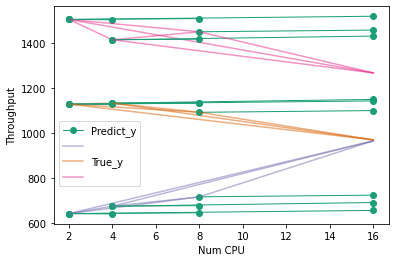

294.74722222222226
Overall ycsb nrmse: 0.3951537473702855


In [30]:
# most similar expr idx
min_run_idx = 0
# min_group = '1'
min_groups = ['1', '7', '8',]

model_dict = [group_to_model_dict[min_group] for min_group in min_groups]
simi_expr = data_all.get_by_run_idx(min_run_idx)

overall_score = predict(model_dict, ycsb_X, ycsb_y, ycsb_expr, 'MARS', True)

print('Overall ycsb nrmse: {}'.format(overall_score))

In [31]:
terminals = [4, 8, 32]
workloads = ['tpcc', 'twitter', 'tpch']
methods = ['MARS']

for me in methods:
    curr_line = ''
    scs = []
    times = []
    for wl in workloads:
        if wl == 'tpch':
            sc = abs(all_results[me][wl][1])
            curr_line += f' {sc:.3f} &'
            scs.append(sc)
            times.append(all_times[me][wl][1])
        else:
            for ter in terminals:
                sc = abs(all_results[me][wl][ter])
                curr_line += f' {sc:.3f} &'
                scs.append(sc)
                times.append(all_times[me][wl][ter])
    curr_line += f' {np.mean(scs):.3}'
    curr_line += " \\\\ \hline \hline"
    curr_line = f'& {me} & ' + f' {np.mean(times):.4f} & ' + curr_line
    print(curr_line)

& MARS &  0.1164 &  0.304 & 0.322 & 0.297 & 0.286 & 0.337 & 0.299 & 0.258 & 0.3 \\ \hline \hline
